<a href="https://colab.research.google.com/github/Ziqi-Li/GEO4162C/blob/spring-24/notebooks/set_covering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Spatial Optimization (2): Set Covering Problem

In this model, a facility can serve all demand nodes that are within a given coverage distance ***Dc*** from the facility. The problem is the place the **minimum** number of facilities so as to ensure that all demand nodes can be served. We assume there are no capacity constraints at the facilities.


**Objective function:** Minimizing the number of placed facilities

**Decision variables:** where to put the facilities and which demand nodes are serviced by which facility location

**Constraints:**
- Every demand node i needs to be served by at least 1 facility
- A node can be serviced by a facility at a certain location if the facility is within ***Dc*** distance
- Each node is either a facility or not

Refer to pg. 28 in the lecture slide.

In this example, we consider a more complicated scenario: when there are already exisiting facilities which cover some locations, where should we place **additional** facilities to meet the coverage requirement? This will involve two steps:
1. Find locations that are not covered
2. Locate new facilities only to cover uncovered locations using spatial optimization

In [1]:
pip install -q pulp

In [2]:
from pulp import *
import numpy as np
import geopandas as gp
import pandas as pd
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt

In [3]:
#read a sample shapefile
georgia_shp = gp.read_file("https://raw.githubusercontent.com/Ziqi-Li/GEO4162C/main/data/georgia/G_utm.shp")

In [4]:
georgia_shp.shape

(172, 18)

Consider we have two exisiting facilities that are located at county 10 and county 100.

In [5]:
exisiting_fac = [10,100] #county 10 and 100 have facilities

<Axes: >

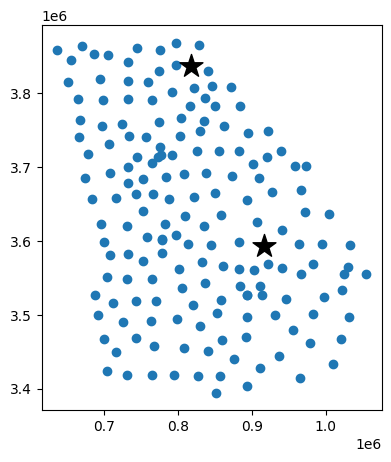

In [6]:
#Plot the faclities (stars) on top of the demand map.
fig, ax = plt.subplots(figsize=(5,5))

georgia_shp.centroid.plot(ax=ax)
georgia_shp.iloc[exisiting_fac,:].centroid.plot(ax=ax,color="black",markersize=300,marker="*")

In [7]:
#Calculate a distance matrix d_ij (n by n)
coords = list(zip(georgia_shp.centroid.x,georgia_shp.centroid.y))

d = cdist(coords,coords)

If we are interested in having an 100km coverage, that is to ensure all locations travel to faclities no further than 100km.

In [8]:
# Threshold coverage distance
Dc = 100000 #100km coverage, change this and re run the code.

Examine the distance matrix to find out which locations are already been covered by facility 10 and 100?

In [9]:
d[10,:] <= Dc

array([ True,  True,  True,  True, False, False, False, False, False,
        True,  True,  True,  True,  True, False,  True, False, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True, False,  True,  True, False,  True, False,
       False,  True, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [10]:
d[100,:] <= Dc

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True, False,  True,
       False, False,  True, False, False, False, False, False,  True,
        True,  True, False, False,  True,  True, False,  True, False,
       False,  True, False,  True, False, False, False,  True,  True,
       False,  True, False, False, False, False, False,  True, False,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False,  True, False,  True,  True, False,
       False,  True,

Make a map showing exisiting covered locations in orange

<Axes: >

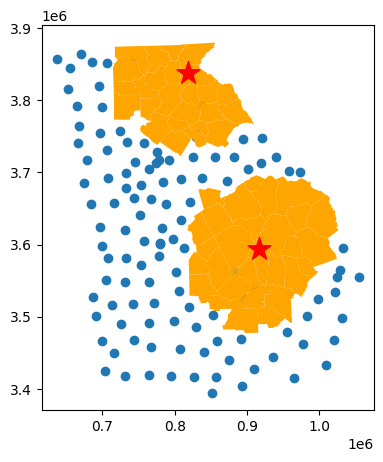

In [11]:
fig, ax = plt.subplots(figsize=(5,5))

georgia_shp.centroid.plot(ax=ax)

georgia_shp.iloc[d[10,:] <=Dc,:].plot(ax=ax,color="orange")
georgia_shp.iloc[d[100,:] <=Dc,:].plot(ax=ax,color="orange")

georgia_shp.iloc[exisiting_fac,:].centroid.plot(ax=ax,color="red",markersize=300,marker="*")

Now lets figure out locations that are not covered.

In [12]:
df1 = georgia_shp.iloc[d[10,:] <= Dc,:]
df2 = georgia_shp.iloc[d[100,:] <= Dc,:]

covered = pd.concat([df1,df2]).drop_duplicates()

Here is a little trick to subset the un covered locations. Now all the further analysis will be performed based on this

In [13]:
uncovered = georgia_shp[~georgia_shp.isin(covered)].dropna()

In [14]:
#create a demand and a facilities variable, indicating the indices of each demand and facility.
#demand node: all counties
#facility: we could build facilities in some counties

demand = list(uncovered.index)
facilities = list(uncovered.index)

In [15]:
#Creata a variable (alpha in the lecture slide pg.28), indicating  whether a node i can be covered by facility j.
a = np.zeros(d.shape)
a[d <= Dc] = 1
a[d > Dc] = 0

In [16]:
# declare facilities variables Xj
X = LpVariable.dicts('X_%s',(facilities),cat='Binary')

In [17]:
#Create an minimization problem
prob = LpProblem('Set_Covering', LpMinimize)

In [18]:
# Objective function: we want to minimize the number of placed facilities
prob += sum([X[j] for j in facilities])

In [19]:
# This constraint implies every demand node i needs to be served by at least 1 facility
for i in demand:
    prob += sum(a[i][j]*X[j] for j in facilities) >= 1


In [20]:
%%time
# Solve the above problem
prob.solve()

print("Status:", LpStatus[prob.status])

Status: Optimal
CPU times: user 12.2 ms, sys: 4.7 ms, total: 16.9 ms
Wall time: 34.7 ms


In [21]:
# The minimal number of facilities with the defiened coverage.
print("Objective: ",value(prob.objective))

Objective:  6.0


In [22]:
# Print the facility nodes.
rslt = []
for v in prob.variables():
    subV = v.name.split('_')

    if subV[0] == "X" and v.varValue == 1:
        rslt.append(int(subV[1]))
        print('Facility Node: ', subV[1])

Facility Node:  145
Facility Node:  150
Facility Node:  24
Facility Node:  49
Facility Node:  79
Facility Node:  96


In [23]:
# Get the geomerty of the facility nodes.
fac_loc = georgia_shp.iloc[rslt,:]

<Axes: >

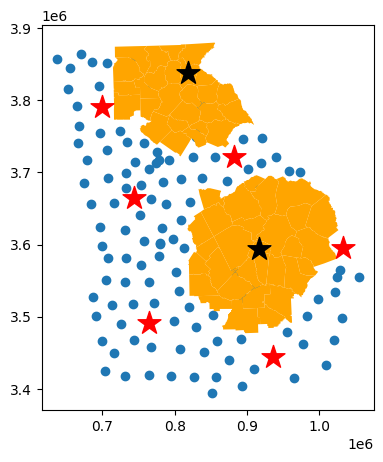

In [24]:
#Plot the faclities (stars) on top of the demand map.
fig, ax = plt.subplots(figsize=(5,5))

georgia_shp.centroid.plot(ax=ax)

georgia_shp.iloc[d[10,:] <=Dc,:].plot(ax=ax,color="orange")
georgia_shp.iloc[d[100,:] <=Dc,:].plot(ax=ax,color="orange")
georgia_shp.iloc[exisiting_fac,:].centroid.plot(ax=ax,color="black",markersize=300,marker="*")


fac_loc.centroid.plot(ax=ax,color="red",markersize=300,marker="*")

We find we still need 6 new facilities in order to fill the gap and to meet the coverage threshold criterion.